In [173]:
import enum
import requests
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List, Optional
from dataclasses import dataclass

In [174]:
API_TOKEN = "73b5db4b-735a-473c-9378-83fbcf97b167cd82fd17-a895-488a-8cfb-e3c4a321c1b1"

In [175]:
@dataclass
class SensorsReading:
    front_distance: float
    right_side_distance: float
    left_side_distance: float
    back_distance: float
    left_45_distance: float
    right_45_distance: float
    rotation_pitch: float
    rotation_yaw: float
    rotation_roll: float
    down_x_offset: float
    down_y_offset: float


class RoboController:

    _BASE_URL = "http://localhost:8801/api/v1/robot-cells"

    def __init__(self, api_token: str, delay: float = 0.02) -> None:
        self._token = api_token
        self._delay = delay

    def command_pwm(self, pwm_l: int, time_l: int,
                    pwm_r: int, time_r: int):
        url = f"http://127.0.0.1:8801/api/v1/robot-motors/move?l={pwm_l}&l_time={time_l}&r={pwm_r}&r_time={time_r}"
        response = requests.post(url)
        if response.status_code != 200:
            raise RuntimeError(f"Received status code {response.status_code}")
    
    def read_sensors(self) -> SensorsReading:
        url = f"{RoboController._BASE_URL}/sensor-data?token={self._token}"
        response = requests.get(url)
        if response.status_code != 200:
            raise RuntimeError(f"Received status code {response.status_code}")
        return SensorsReading(**response.json())


    def _movement_request(self, direction: str) -> bool:
        url = f"{RoboController._BASE_URL}/{direction}?token={self._token}"
        response = requests.post(url)
        if response.status_code != 200:
            raise RuntimeError(f"Received status code {response.status_code}")
        time.sleep(self._delay)
        return True

In [176]:
controller = RoboController(API_TOKEN)

In [122]:
dataset = [] # pwm_r, pwm_l, time_r, time_l, x_init, y_init, yaw_init, x_new, y_new, yaw_new

In [135]:
reading = controller.read_sensors()
pwm_r = -150
pwm_l = -250
time_l = 0.2
time_r = 0.2
x_init = reading.down_x_offset
y_init = reading.down_y_offset
yaw_init = reading.rotation_yaw

controller.command_pwm(pwm_l=pwm_l,
                       time_l=time_l,
                       pwm_r=pwm_r,
                       time_r=time_r)
time.sleep(3)

reading = controller.read_sensors()

x_new = reading.down_x_offset
y_new = reading.down_y_offset
yaw_new = reading.rotation_yaw

dataset.append([pwm_r, pwm_l, time_r, time_l, x_init, y_init, yaw_init, x_new, y_new, yaw_new])

In [138]:
dataset

[[255, 255, 0.2, 0.2, -1163.32, -1254.07, -0.0, -1083.45, -1254.06, -0.01],
 [200, 200, 0.2, 0.2, -1083.46, -1254.06, -0.01, -1044.32, -1254.06, 0.03],
 [180, 180, 0.2, 0.2, -1044.32, -1254.06, 0.03, -1016.07, -1254.05, 0.06],
 [225, 225, 0.2, 0.2, -1016.07, -1254.05, 0.06, -959.72, -1253.98, 0.07],
 [240, 240, 0.2, 0.2, -959.73, -1253.98, 0.07, -892.34, -1253.9, 0.08],
 [221, 221, 0.2, 0.2, -892.35, -1253.9, 0.08, -838.94, -1253.82, 0.09],
 [-255, -255, 0.2, 0.2, -838.94, -1253.82, 0.09, -919.38, -1253.92, 0.09],
 [-220, -220, 0.2, 0.2, -919.37, -1253.92, 0.09, -972.43, -1254.0, 0.07],
 [-245, -245, 0.2, 0.2, -972.43, -1254.0, 0.07, -1044.21, -1254.08, 0.04],
 [-175, -175, 0.2, 0.2, -1044.2, -1254.08, 0.04, -1070.17, -1254.1, 0.01],
 [-140, -140, 0.2, 0.2, -1070.17, -1254.1, 0.01, -1082.13, -1254.1, -0.01]]

In [115]:
len(dataset)

8

In [139]:
df = pd.DataFrame(dataset, columns=["pwm_r", "pwm_l", "time_r", "time_l", "x_init", "y_init", "yaw_init", "x_new", "y_new", "yaw_new"])
df.to_csv("pwm_dataset_linear.csv", index=False)

In [140]:
df = pd.read_csv("pwm_dataset_linear.csv")

In [213]:
pwms, vels = [], []
for i in range(len(df)):
    linear_vel = [df["x_new"][i] - df["x_init"][i],
                  df["y_new"][i] - df["y_init"][i]]
    linear_vel = np.array(linear_vel) / df["time_r"][i]
    pwm = df["pwm_r"][i]
    vels.append(linear_vel)
    pwms.append(pwm)
pwms = np.array(pwms, dtype=float)
vels = np.array(vels)

vels = vels[np.argsort(pwms)]
pwms = np.sort(pwms)
vels = vels[:, 0]

In [214]:
pwms

array([-255., -245., -220., -175., -140.,  180.,  200.,  221.,  225.,
        240.,  255.])

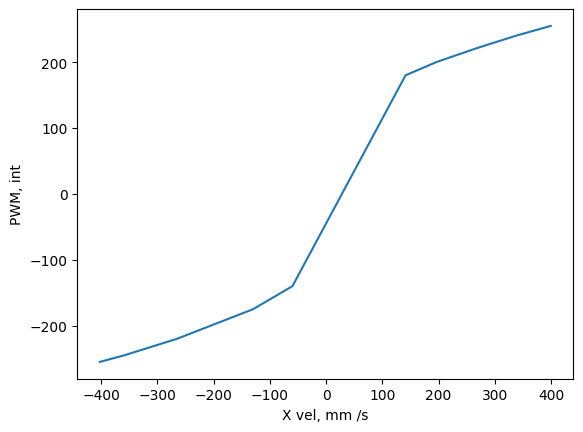

In [215]:
plt.plot(vels, pwms)
plt.xlabel("X vel, mm /s")
plt.ylabel("PWM, int")
plt.show()

In [216]:
coefs = np.polyfit(vels, pwms, 7)
print(coefs)

[-4.21212426e-16  5.28674735e-14  1.58051392e-10 -1.61960662e-08
 -2.08418413e-05  1.47084272e-03  1.65146419e+00 -3.64546663e+01]


In [217]:
def apply_polynomial(x: np.ndarray, coefs: np.ndarray):
    result = coefs[-1]
    degree = coefs.shape[0] - 1
    for i in range(degree):
        result = result + coefs[i] * (x ** (degree - i))
    return result

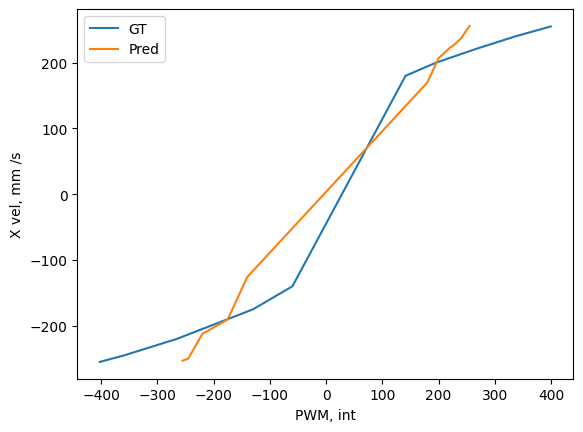

In [218]:
plt.plot(vels, pwms, label="GT")
predicted = apply_polynomial(vels, coefs)
plt.plot(pwms, predicted, label="Pred")
plt.xlabel("PWM, int")
plt.ylabel("X vel, mm /s")
plt.legend()
plt.show()

In [228]:
maze_coords = np.load("maze_coords.npy")

In [229]:
maze_coords[0, 0]

array([ 1253.94, -1254.48])

In [238]:
dt = 0.2
vel = 100.

pwm = int(apply_polynomial(vel, coefs))
print(pwm)


122


In [247]:
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint=0, output_limits=(None, None)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.output_limits = output_limits
        
        self._integral = 0
        self._previous_error = None

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self._integral += error * dt
        derivative = 0 if self._previous_error is None else (error - self._previous_error) / dt

        output = (self.Kp * error) + (self.Ki * self._integral) + (self.Kd * derivative)
        self._previous_error = error

        if self.output_limits[0] is not None:
            output = max(self.output_limits[0], output)
        if self.output_limits[1] is not None:
            output = min(self.output_limits[1], output)
        
        return output

In [269]:
Kp = 0.5
Ki = 0.3
Kd = 0.05
setpoint = 0.

pid = PID(Kp, Ki, Kd, setpoint, output_limits=(0, 255))

In [280]:
Kp = 1.
Ki = 0.1
Kd = 1.
setpoint = 0.

pid = PID(Kp, Ki, Kd, setpoint, output_limits=(0, 255))

controller = RoboController(API_TOKEN)

dt = 0.1
pwm = 100

target_point = maze_coords[14, 0]

while(True):
    reading = controller.read_sensors()
    coord = np.array([reading.down_x_offset, reading.down_y_offset])
    error = -np.linalg.norm(coord - target_point)
    if abs(error) < 100:
        controller.command_pwm(pwm_l=0,
                               time_l=dt,
                               pwm_r=0,
                               time_r=dt)
        print("Reached")
        break
    pwm = pid.update(error, dt)
    pwm = int(pwm)
    print(pwm)
    controller.command_pwm(pwm_l=pwm,
                    time_l=dt,
                    pwm_r=pwm,
                    time_r=dt)
    time.sleep(dt)

168
164
147
124
103
86
72
61
53
47
41
Reached


In [ ]:
p